In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks

## Lecture 09b
## Introduction to Pytorch - Framework Demo
- MNIST dataset
- pytorch implementation Custom Dataset Class with loader


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
modelSubDir = 'torch_fashion'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

## Read MNIST FASHION data set
<img src = '../../images/pytorch_fashion_mnist.png' alt = 'pytorch_fashion_mnist'>

In [4]:
trainFilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
testFilepath = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(trainFilepath)
test_df = pd.read_csv(testFilepath)
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class_labels = {0 : 'T-shirt/top',
                1  : 'Trouser',
                2  : 'Pullover',
                3 : 'Dress',
                4 : 'Coat',
                5 : 'Sandal',
                6 : 'Shirt',
                7 : 'Sneaker',
                8 : 'Bag',
                9 : 'Ankle boot'}

## All about CUDA

In [6]:
print ('Is CUDA available: ', torch.cuda.is_available())

print ('CUDA version: ', torch.version.cuda )

print ('Current Device ID: ', torch.cuda.current_device())

print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available:  True
CUDA version:  12.1
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU


In [7]:
# Get cpu or gpu device for training.

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

Using cuda device


In [8]:
'''
In this code, we define a custom dataset called FashionDS that takes a DataFrame as input. 

'''
class FashionDS(Dataset):
    
    def __init__(self, 
                 dataframe: pd.DataFrame, 
                 device : str = device
                ):
        
        self.df = dataframe
        self.device = device
        
        self.labels = self.df['label'].to_numpy()
        X = self.df.drop('label', axis = 1).to_numpy()
        
        self.features = X/255.  
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        # Extract features and label from the dataframe row
        features = self.features[index]
        label = self.labels[index]
        
        # Convert to PyTorch tensors
        features = torch.tensor(features, 
                                dtype=torch.float32, 
                                device=self.device)
        
        label = torch.tensor(label, 
                             dtype=torch.int64, 
                             device=self.device)
        
        return features, label

In [9]:

train_ds = FashionDS(train_df)

test_ds = FashionDS(test_df)


In [10]:
train_ds

In [11]:
train_loader = DataLoader(train_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(test_ds, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

In [12]:
train_loader

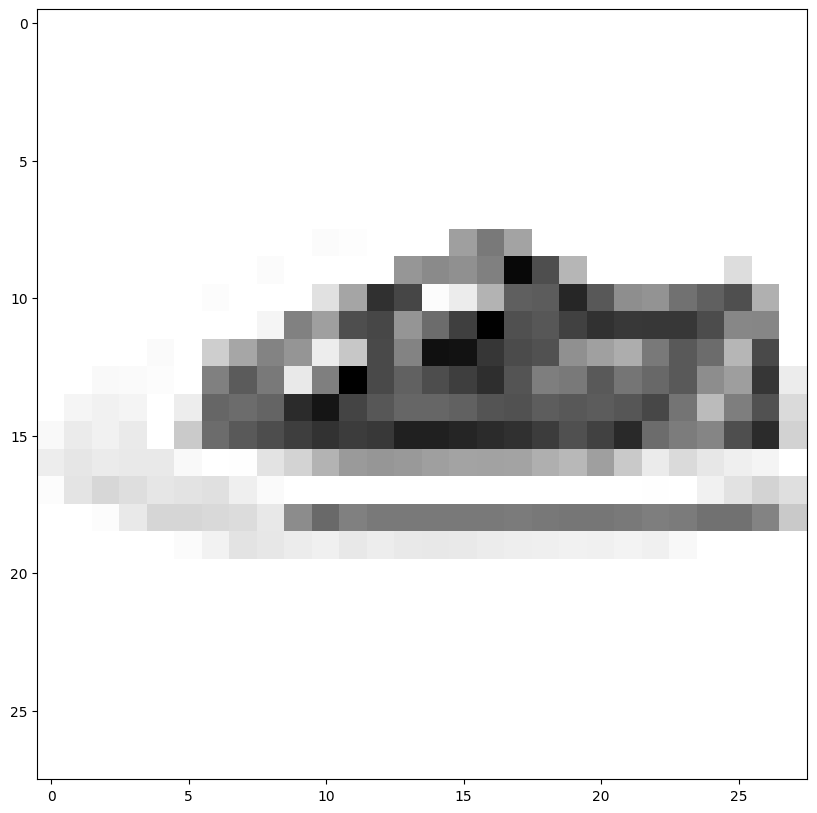

In [13]:
images, targets = next(iter(train_loader))
images = images.cpu().numpy()
plt.imshow(images[0].reshape(28,28), cmap=plt.cm.binary)

In [14]:
images, targets = next(iter(train_loader))

images = images.cpu().numpy()

targets = targets.cpu().numpy()

targets

array([2, 1, 6, 3, 5, 4, 7, 9, 1, 6, 3, 6, 7, 1, 4, 3, 1, 4, 0, 7, 2, 5,
       7, 8, 5, 6, 5, 1, 7, 7, 4, 0])

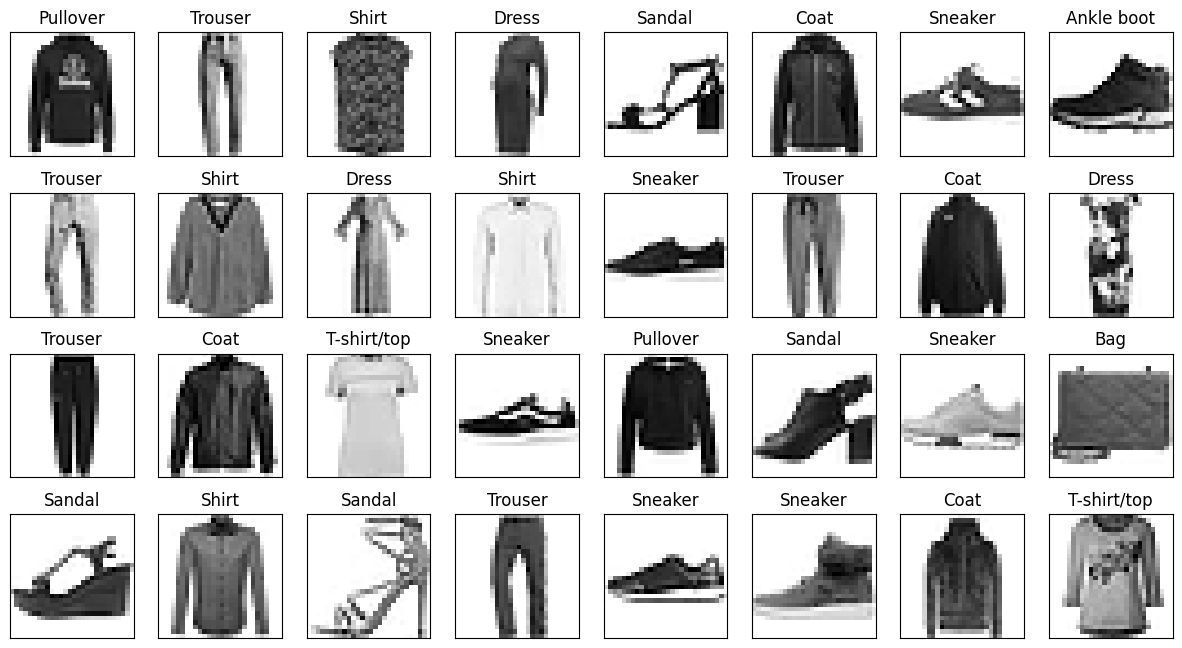

In [15]:
plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):

    plt.subplot(4,8, i+1)
    
    plt.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)

    plt.xticks([])

    plt.yticks([])

    plt.grid(False)
    plt.title(class_labels[targets[i]])

In [16]:
input_shape = train_df.shape[1] -1
input_shape

784

In [17]:
128/32

4.0

In [18]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()

        # define Dropout rates
        self.dor1 = 0.3
        self.dor2 = 0.5

        # Layer 1 
        self.layer1 = nn.Linear(input_dim,128) # 784 x 128 /6
        self.bn1 = nn.BatchNorm1d(128)
        self.activ1 = nn.Tanh()
        self.dropout1 = nn.Dropout(self.dor1)


        # Layer 2
        self.layer2 = nn.Linear(128, 32)   # 128 x 32 / 4
        self.bn2 = nn.BatchNorm1d(32)
        self.activ2 = nn.Tanh()
        self.dropout2 = nn.Dropout(self.dor2)

        # Layer 3
        self.layer3 = nn.Linear(32, 10)  # 32 X 10 / 3
        self.softmax = nn.LogSoftmax(dim = 1)
         
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.activ2(x)
        x = self.dropout2(x)
        
        x = self.layer3(x)
        return self.softmax(x)

net = Model(input_dim=input_shape).to(device) # Create model on GPU
print (net)

Model(
  (layer1): Linear(in_features=784, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ1): Tanh()
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=128, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activ2): Tanh()
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [19]:
# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # cross entropy loss

loss, tloss = [],[]
acc, tacc = [],[]
n_epoch = []

optimizer = torch.optim.Adam(net.parameters(), 
                             lr=ALPHA, 
                             weight_decay=1e-5) # weight decay

# Train the model for multiple epochs

for epoch in range(EPOCHS):
    
    # Training loop
    train_loss = 0.0
    train_acc = 0.0
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        preds = torch.argmax(outputs, dim = 1)
        
        batch_loss = loss_fn(outputs, labels)
        batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
        
        batch_loss.backward()
        
        optimizer.step()
        
        train_loss += batch_loss.item() * inputs.size(0)
        train_acc += batch_acc * inputs.size(0)
    
    train_loss /= len(train_ds)
    train_acc /= len(train_ds)
    
    loss.append(train_loss)
    acc.append(train_acc)
    
    # Testing loop
    test_loss = 0.0
    test_acc = 0.0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs, labels = data
            
            outputs = net(inputs)
            
            preds = torch.argmax(outputs, dim = 1)
            
            batch_loss = loss_fn(outputs, labels)

            batch_acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
            
            test_loss += batch_loss.item() * inputs.size(0)
            test_acc += batch_acc* inputs.size(0)
        
        test_loss /= len(test_ds)
        test_acc /= len(test_ds)
    
        tloss.append(test_loss)
        tacc.append(test_acc)
    n_epoch.append(epoch)
    
    if epoch%5 == 0:
        print(f'At epoch {epoch} | Loss - train:{train_loss:.4f}, test:{test_loss:.4f} | Acc - train:{train_acc:.4f}, test:{test_acc:.4f}')

At epoch 0 | Loss - train:0.7029, test:0.5834 | Acc - train:0.7777, test:0.8071
At epoch 5 | Loss - train:0.4840, test:0.4913 | Acc - train:0.8365, test:0.8364
At epoch 10 | Loss - train:0.4416, test:0.4703 | Acc - train:0.8495, test:0.8434
At epoch 15 | Loss - train:0.4211, test:0.4519 | Acc - train:0.8582, test:0.8473
At epoch 20 | Loss - train:0.3977, test:0.4504 | Acc - train:0.8639, test:0.8545
At epoch 25 | Loss - train:0.3863, test:0.4414 | Acc - train:0.8668, test:0.8542


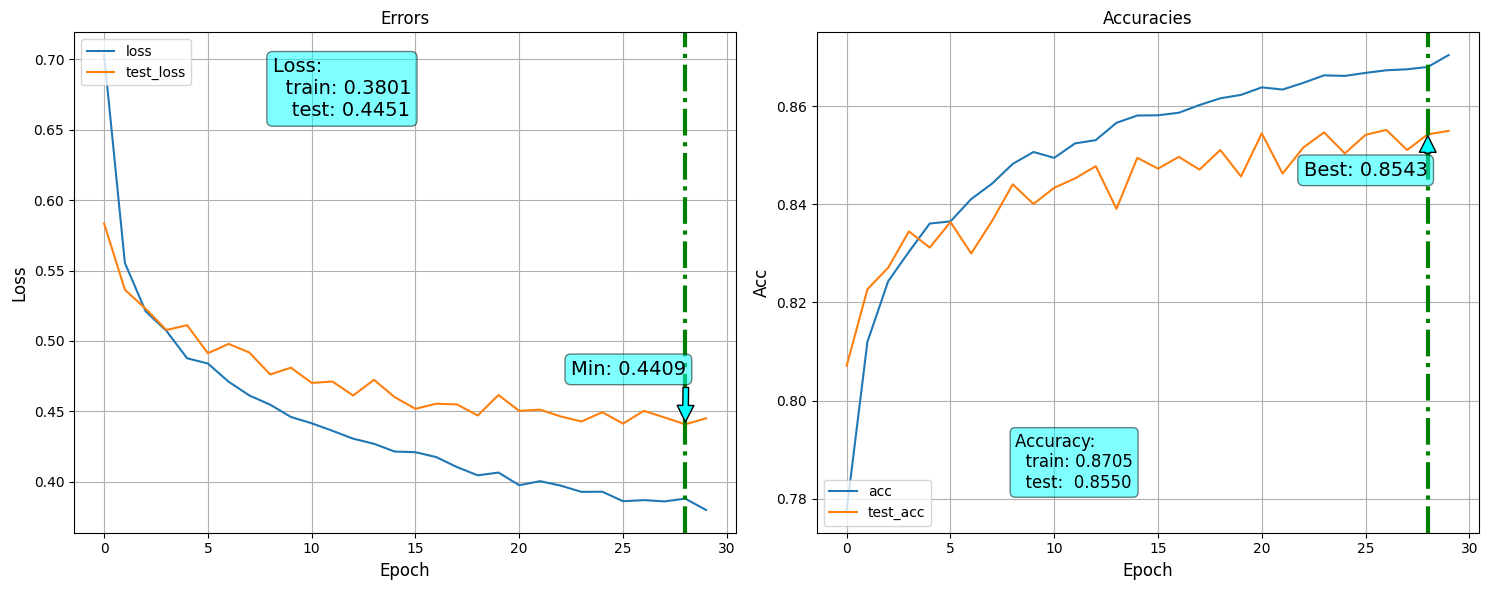

In [20]:
loss_df = pd.DataFrame({'epoch' : n_epoch, 'loss' : loss, 'test_loss': tloss, 'acc' : acc, 'test_acc': tacc})
fn_plot_torch_hist(loss_df)

In [21]:
y_train = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_train.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [22]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82      6000
           1       0.97      0.97      0.97      6000
           2       0.79      0.79      0.79      6000
           3       0.88      0.87      0.88      6000
           4       0.77      0.81      0.79      6000
           5       0.94      0.95      0.94      6000
           6       0.72      0.65      0.68      6000
           7       0.93      0.92      0.93      6000
           8       0.96      0.96      0.96      6000
           9       0.95      0.95      0.95      6000

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



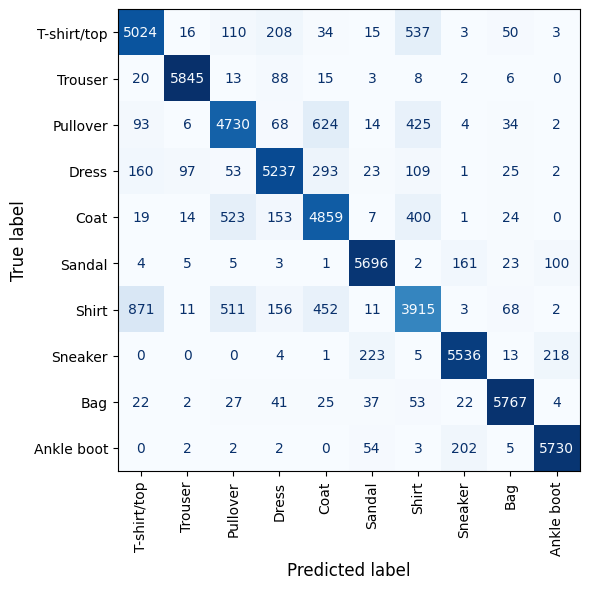

In [23]:
fn_plot_confusion_matrix(y_train, y_pred, class_labels)

In [24]:
X = train_df.drop('label', axis = 1).to_numpy()/255.
y_true = train_df['label'].to_numpy()
X = torch.tensor(X, dtype = torch.float32).to(device)
#X

In [25]:
with torch.inference_mode():
    preds = net(X)
    y_pred = preds.argmax(dim = 1)
    y_pred = y_pred.cpu().numpy()
y_pred.shape

(60000,)

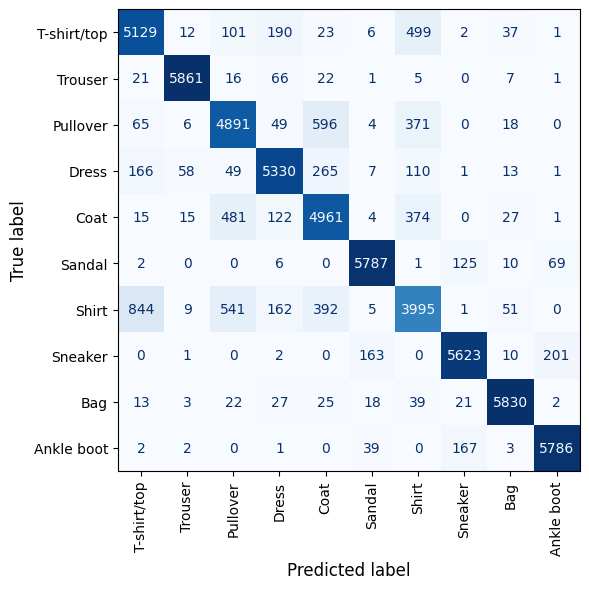

In [26]:
fn_plot_confusion_matrix(y_true, y_pred, class_labels)

In [27]:
y_test = []
y_pred = []
for i, data in enumerate(train_loader):
    
    inputs, labels = data
    
    outputs = net(inputs)
    
    preds = torch.argmax(outputs, dim = 1)

    y_test.extend(labels.cpu().numpy())

    y_pred.extend(preds.cpu().numpy())

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.83      6000
           1       0.97      0.97      0.97      6000
           2       0.79      0.80      0.79      6000
           3       0.88      0.88      0.88      6000
           4       0.77      0.80      0.79      6000
           5       0.94      0.95      0.94      6000
           6       0.72      0.65      0.68      6000
           7       0.94      0.92      0.93      6000
           8       0.96      0.96      0.96      6000
           9       0.95      0.96      0.95      6000

    accuracy                           0.87     60000
   macro avg       0.87      0.87      0.87     60000
weighted avg       0.87      0.87      0.87     60000



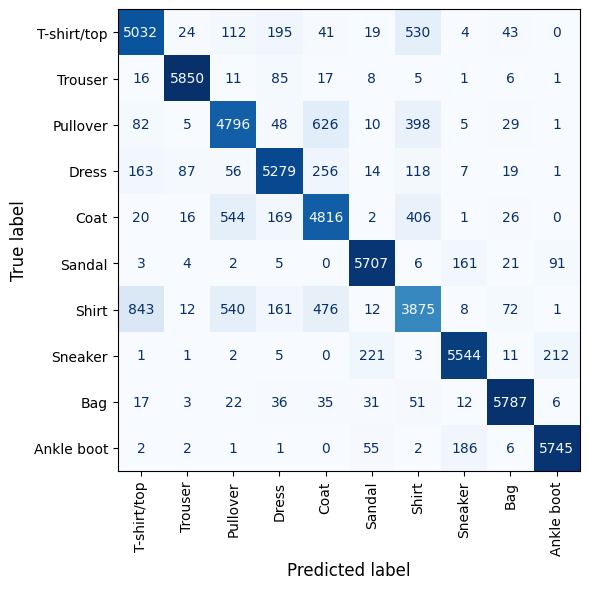

In [29]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)

In [30]:
images, labels = next(iter(test_loader))
    
outputs = net(images)
    
preds = torch.argmax(outputs, dim = 1)

preds = preds.cpu().numpy()
labels = labels.cpu().numpy()

images = images.cpu().numpy()

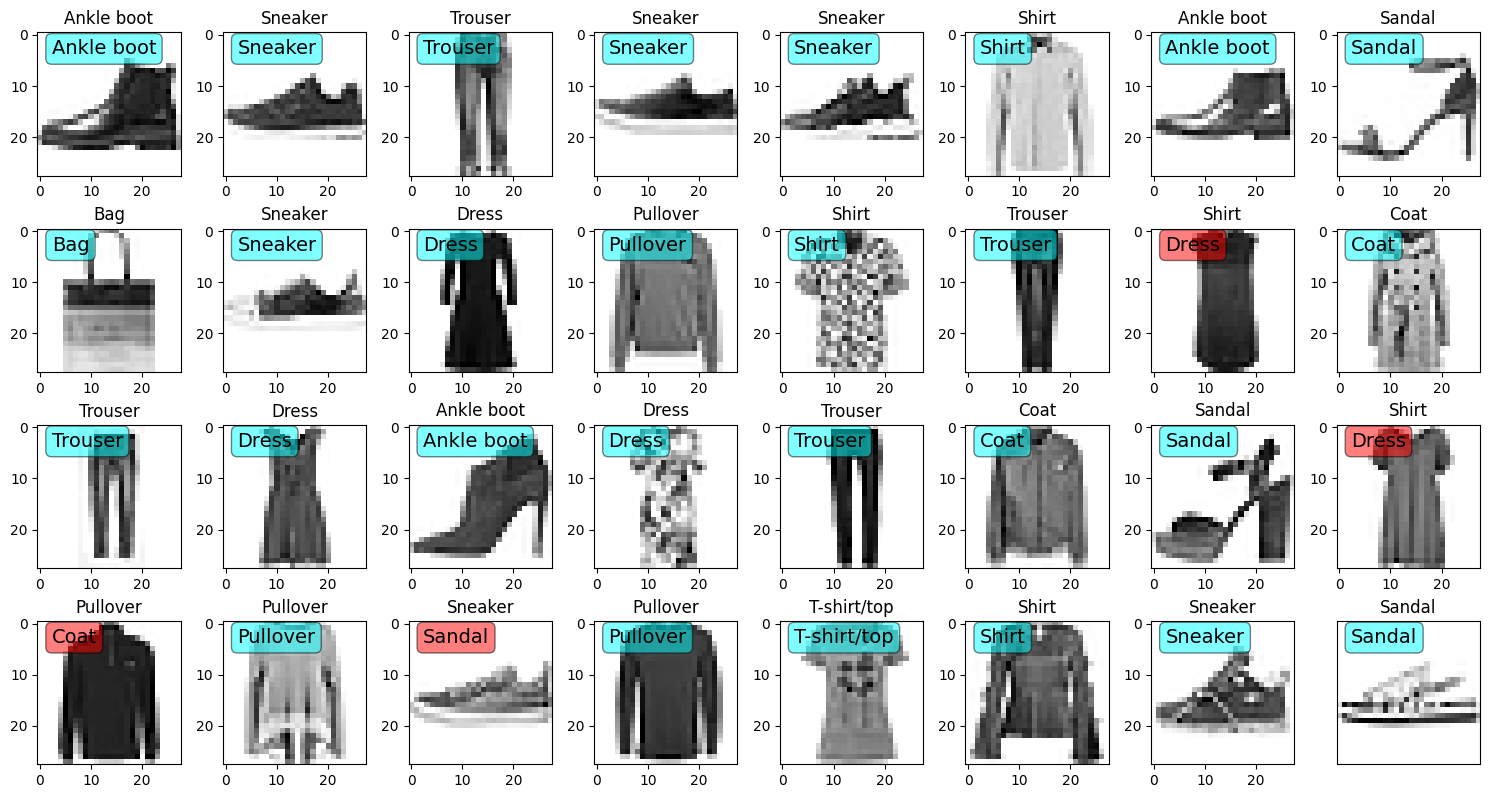

In [34]:
fig, axes = plt.subplots(4,8, figsize = (15,8)) # Instantiate
axes = axes.ravel() # one dimensional array

for i in range(BATCH_SIZE):
    ax = axes[i] # extract axis on which to plot

    # properties  matplotlib.patch.Patch 
    color = 'cyan'
    if labels[i]!= preds[i]:
        color = 'red'
    
    ax.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)

    plt.xticks([])

    plt.yticks([])

    ax.grid(False)

    ax.set_title(class_labels[labels[i]])

    props = dict(boxstyle='round', facecolor=color, alpha=0.5)

    # place a text box in upper middle in axes coords
    ax.text(0.1, 0.95, class_labels[preds[i]], transform=ax.transAxes, 
            fontsize=14, verticalalignment='top', bbox=props)
    
plt.tight_layout()